<a href="https://colab.research.google.com/github/ashwindaswani/cartoon-GAN/blob/main/pokeGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


In [3]:
dataroot = "/content/drive/My Drive/GAN"
workers = 2
batch_size = 64
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 25
lr = 0.0002
beta1 = 0.5
ngpu = 1

In [4]:
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


Random Seed:  9614


In [5]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [6]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [7]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

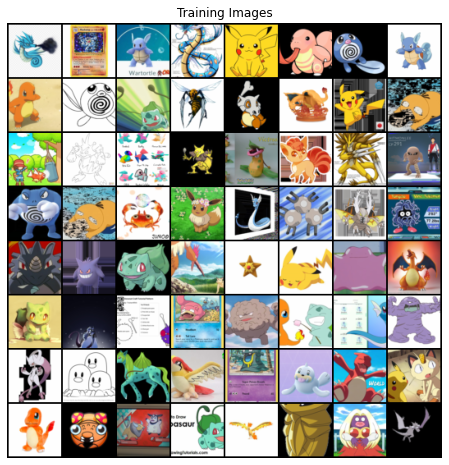

In [8]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [11]:

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [12]:
# Create the generator
netG = Generator(ngpu).to(device)



# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [13]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [14]:
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [15]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [16]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    print("EPOCH================"+ str(epoch))
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        print()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
EPOCH================0

[0/25][0/167]	Loss_D: 1.6248	Loss_G: 5.6082	D(x): 0.4851	D(G(z)): 0.4585 / 0.0044





/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "

















































[0/25][50/167]	Loss_D: 0.0251	Loss_G: 30.2681	D(x): 0.9767	D(G(z)): 0.0000 / 0.0000


















































[0/25][100/167]	Loss_D: 0.4827	Loss_G: 15.5953	D(x): 0.7452	D(G(z)): 0.0001 / 0.0000





























/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "

























[0/25][150/167]	Loss_D: 0.9531	Loss_G: 5.3738	D(x): 0.8273	D(G(z)): 0.4288 / 0.0276
















EPOCH================1

[1/25][0/167]	Loss_D: 1.8161	Loss_G: 5.5260	D(x): 0.9468	D(G(z)): 0.6940 / 0.0074

















































/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "





[1/25][50/167]	Loss_D: 0.1925	Loss_G: 5.4248	D(x): 0.8708	D(G(z)): 0.0138 / 0.0088


















































[1/25][100/167]	Loss_D: 0.1943	Loss_G: 5.8134	D(x): 0.9315	D(G(z)): 0.0927 / 0.0058


















































[1/25][150/167]	Loss_D: 0.1761	Loss_G: 6.4163	D(x): 0.9555	D(G(z)): 0.1004 / 0.0030
















EPOCH================2

[2/25][0/167]	Loss_D: 0.2439	Loss_G: 5.9037	D(x): 0.8528	D(G(z)): 0.0068 / 0.0136






/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "






[2/25][50/167]	Loss_D: 0.1135	Loss_G: 5.5877	D(x): 0.9511	D(G(z)): 0.0538 / 0.0097


















































[2/25][100/167]	Loss_D: 0.7705	Loss_G: 2.7967	D(x): 0.7116	D(G(z)): 0.2465 / 0.0943


















































[2/25][150/167]	Loss_D: 2.0053	Loss_G: 2.0416	D(x): 0.2618	D(G(z)): 0.0028 / 0.2053
















EPOCH================3

[3/25][0/167]	Loss_D: 0.6775	Loss_G: 5.7639	D(x): 0.6269	D(G(z)): 0.0089 / 0.0109









/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "













































[3/25][50/167]	Loss_D: 1.3606	Loss_G: 0.1210	D(x): 0.3462	D(G(z)): 0.0669 / 0.8892




























/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


























[3/25][100/167]	Loss_D: 1.1280	Loss_G: 4.1574	D(x): 0.7381	D(G(z)): 0.3409 / 0.0485


















































[3/25][150/167]	Loss_D: 0.7665	Loss_G: 1.3858	D(x): 0.5909	D(G(z)): 0.1049 / 0.3134
















EPOCH================4

[4/25][0/167]	Loss_D: 0.6335	Loss_G: 6.6660	D(x): 0.9799	D(G(z)): 0.4102 / 0.0023






































/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
















[4/25][50/167]	Loss_D: 0.2941	Loss_G: 3.8693	D(x): 0.8919	D(G(z)): 0.1442 / 0.0357


















































[4/25][100/167]	Loss_D: 0.1699	Loss_G: 3.8746	D(x): 0.9247	D(G(z)): 0.0821 / 0.0285































/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "























[4/25][150/167]	Loss_D: 0.5090	Loss_G: 4.1992	D(x): 0.8685	D(G(z)): 0.2479 / 0.0554
















EPOCH================5

[5/25][0/167]	Loss_D: 0.3869	Loss_G: 3.0917	D(x): 0.7888	D(G(z)): 0.1032 / 0.0721

































/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "





















[5/25][50/167]	Loss_D: 0.1705	Loss_G: 5.4808	D(x): 0.8742	D(G(z)): 0.0189 / 0.0058





































/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "

















[5/25][100/167]	Loss_D: 1.8188	Loss_G: 6.6823	D(x): 0.9686	D(G(z)): 0.7281 / 0.0052


















































[5/25][150/167]	Loss_D: 0.8596	Loss_G: 5.1182	D(x): 0.8173	D(G(z)): 0.3941 / 0.0160
















EPOCH================6

[6/25][0/167]	Loss_D: 0.5699	Loss_G: 2.3260	D(x): 0.7417	D(G(z)): 0.1502 / 0.1443


















































[6/25][50/167]	Loss_D: 0.9334	Loss_G: 2.9346	D(x): 0.7498	D(G(z)): 0.3693 / 0.1008






/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
















































[6/25][100/167]	Loss_D: 0.9795	Loss_G: 8.8087	D(x): 0.9471	D(G(z)): 0.5303 / 0.0011


















/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "




































[6/25][150/167]	Loss_D: 0.5731	Loss_G: 2.5217	D(x): 0.7144	D(G(z)): 0.0980 / 0.1398
















EPOCH================7

[7/25][0/167]	Loss_D: 1.2473	Loss_G: 2.0781	D(x): 0.3793	D(G(z)): 0.0074 / 0.2072









/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "













































[7/25][50/167]	Loss_D: 0.2759	Loss_G: 4.7112	D(x): 0.9752	D(G(z)): 0.2016 / 0.0124





































/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "

















[7/25][100/167]	Loss_D: 0.5244	Loss_G: 2.6532	D(x): 0.8236	D(G(z)): 0.2324 / 0.1026


















































[7/25][150/167]	Loss_D: 1.1191	Loss_G: 1.5423	D(x): 0.5831	D(G(z)): 0.2420 / 0.3331
















EPOCH================8

[8/25][0/167]	Loss_D: 0.3901	Loss_G: 3.1799	D(x): 0.7520	D(G(z)): 0.0565 / 0.0708


















































[8/25][50/167]	Loss_D: 0.2590	Loss_G: 3.5937	D(x): 0.8763	D(G(z)): 0.0921 / 0.0459

















/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "





































[8/25][100/167]	Loss_D: 0.3401	Loss_G: 2.9987	D(x): 0.8728	D(G(z)): 0.1613 / 0.0708




















/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


































[8/25][150/167]	Loss_D: 0.5785	Loss_G: 3.2650	D(x): 0.7623	D(G(z)): 0.2225 / 0.0571
















EPOCH================9

[9/25][0/167]	Loss_D: 0.3052	Loss_G: 4.4720	D(x): 0.7833	D(G(z)): 0.0335 / 0.0222



















































/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



[9/25][50/167]	Loss_D: 0.6704	Loss_G: 5.3368	D(x): 0.9410	D(G(z)): 0.4047 / 0.0066























/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "































[9/25][100/167]	Loss_D: 1.0853	Loss_G: 5.0679	D(x): 0.8611	D(G(z)): 0.5090 / 0.0117


















































[9/25][150/167]	Loss_D: 0.3970	Loss_G: 3.1829	D(x): 0.7823	D(G(z)): 0.0937 / 0.0584
















EPOCH================10

[10/25][0/167]	Loss_D: 1.5385	Loss_G: 7.2917	D(x): 0.9877	D(G(z)): 0.6924 / 0.0012







/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "















































[10/25][50/167]	Loss_D: 0.3452	Loss_G: 3.5870	D(x): 0.8936	D(G(z)): 0.1786 / 0.0437








































/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "














[10/25][100/167]	Loss_D: 0.4147	Loss_G: 3.0070	D(x): 0.8105	D(G(z)): 0.1598 / 0.0639


















































[10/25][150/167]	Loss_D: 0.5142	Loss_G: 2.6798	D(x): 0.7887	D(G(z)): 0.1782 / 0.1068
















EPOCH================11

[11/25][0/167]	Loss_D: 0.6733	Loss_G: 3.0632	D(x): 0.7950	D(G(z)): 0.2788 / 0.0625


































/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "




















[11/25][50/167]	Loss_D: 0.8492	Loss_G: 5.2464	D(x): 0.9305	D(G(z)): 0.4695 / 0.0080











































/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "











[11/25][100/167]	Loss_D: 0.6195	Loss_G: 2.8011	D(x): 0.6475	D(G(z)): 0.0793 / 0.0936


















































[11/25][150/167]	Loss_D: 0.6917	Loss_G: 3.6912	D(x): 0.7655	D(G(z)): 0.2590 / 0.0403
















EPOCH================12

[12/25][0/167]	Loss_D: 0.8100	Loss_G: 1.9544	D(x): 0.5689	D(G(z)): 0.0978 / 0.2028















































/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "







[12/25][50/167]	Loss_D: 0.4434	Loss_G: 3.8128	D(x): 0.9077	D(G(z)): 0.2595 / 0.0356


















































[12/25][100/167]	Loss_D: 0.5943	Loss_G: 2.1229	D(x): 0.6758	D(G(z)): 0.0978 / 0.1775














































/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "








[12/25][150/167]	Loss_D: 0.6270	Loss_G: 2.7515	D(x): 0.6753	D(G(z)): 0.1538 / 0.0872
















EPOCH================13

[13/25][0/167]	Loss_D: 0.8390	Loss_G: 4.0332	D(x): 0.8784	D(G(z)): 0.4343 / 0.0318


















































[13/25][50/167]	Loss_D: 0.5136	Loss_G: 2.0366	D(x): 0.7290	D(G(z)): 0.1201 / 0.2036










































/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "












[13/25][100/167]	Loss_D: 0.7370	Loss_G: 4.5611	D(x): 0.8195	D(G(z)): 0.3578 / 0.0155


















































[13/25][150/167]	Loss_D: 0.4116	Loss_G: 2.8007	D(x): 0.8681	D(G(z)): 0.2122 / 0.0939
















EPOCH================14

[14/25][0/167]	Loss_D: 0.5983	Loss_G: 3.4614	D(x): 0.6312	D(G(z)): 0.0213 / 0.0670


















































[14/25][50/167]	Loss_D: 0.7320	Loss_G: 1.8688	D(x): 0.6388	D(G(z)): 0.1824 / 0.1836


















































[14/25][100/167]	Loss_D: 0.4155	Loss_G: 2.1744	D(x): 0.7938	D(G(z)): 0.1337 / 0.1598






















/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
































[14/25][150/167]	Loss_D: 1.0102	Loss_G: 5.3776	D(x): 0.9769	D(G(z)): 0.5388 / 0.0082






/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "














EPOCH================15

[15/25][0/167]	Loss_D: 0.4445	Loss_G: 3.1590	D(x): 0.8545	D(G(z)): 0.2150 / 0.0595

























/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "





























[15/25][50/167]	Loss_D: 0.4326	Loss_G: 2.9350	D(x): 0.7943	D(G(z)): 0.1526 / 0.0776


















































[15/25][100/167]	Loss_D: 0.3268	Loss_G: 2.8507	D(x): 0.7865	D(G(z)): 0.0551 / 0.0913


















































[15/25][150/167]	Loss_D: 0.3485	Loss_G: 4.2714	D(x): 0.8673	D(G(z)): 0.1487 / 0.0217









/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "











EPOCH================16

[16/25][0/167]	Loss_D: 0.8422	Loss_G: 3.3465	D(x): 0.5248	D(G(z)): 0.0092 / 0.0828


















































[16/25][50/167]	Loss_D: 0.3449	Loss_G: 3.0708	D(x): 0.8993	D(G(z)): 0.1921 / 0.0563


























/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "








[16/25][100/167]	Loss_D: 0.3384	Loss_G: 4.6533	D(x): 0.8818	D(G(z)): 0.1641 / 0.0163


















































[16/25][150/167]	Loss_D: 0.6287	Loss_G: 8.7580	D(x): 0.9801	D(G(z)): 0.4174 / 0.0003
















EPOCH================17

[17/25][0/167]	Loss_D: 0.2372	Loss_G: 3.7767	D(x): 0.9271	D(G(z)): 0.1310 / 0.0380

































/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "





















[17/25][50/167]	Loss_D: 0.2537	Loss_G: 3.6082	D(x): 0.8840	D(G(z)): 0.1050 / 0.0434


















































[17/25][100/167]	Loss_D: 0.6508	Loss_G: 4.9949	D(x): 0.9487	D(G(z)): 0.3588 / 0.0132


















































[17/25][150/167]	Loss_D: 0.1987	Loss_G: 3.9316	D(x): 0.9393	D(G(z)): 0.1091 / 0.0286
















EPOCH================18

[18/25][0/167]	Loss_D: 0.3994	Loss_G: 3.7524	D(x): 0.8459	D(G(z)): 0.1737 / 0.0421


















































[18/25][50/167]	Loss_D: 0.3327	Loss_G: 5.0056	D(x): 0.9493	D(G(z)): 0.2207 / 0.0109


















































[18/25][100/167]	Loss_D: 0.4179	Loss_G: 2.7868	D(x): 0.7380	D(G(z)): 0.0647 / 0.0931










































/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "












[18/25][150/167]	Loss_D: 0.4817	Loss_G: 3.2296	D(x): 0.7319	D(G(z)): 0.0511 / 0.0600









/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "











EPOCH================19

[19/25][0/167]	Loss_D: 0.4480	Loss_G: 4.9625	D(x): 0.9874	D(G(z)): 0.2904 / 0.0104


















































[19/25][50/167]	Loss_D: 0.2004	Loss_G: 2.7580	D(x): 0.9015	D(G(z)): 0.0806 / 0.0909




/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "






[19/25][100/167]	Loss_D: 0.1677	Loss_G: 4.7714	D(x): 0.9215	D(G(z)): 0.0727 / 0.0202


















































[19/25][150/167]	Loss_D: 0.2787	Loss_G: 3.4661	D(x): 0.8009	D(G(z)): 0.0330 / 0.0472
















EPOCH================20

[20/25][0/167]	Loss_D: 0.3456	Loss_G: 2.6921	D(x): 0.7533	D(G(z)): 0.0254 / 0.1094







































/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "















[20/25][50/167]	Loss_D: 0.7280	Loss_G: 6.6363	D(x): 0.9918	D(G(z)): 0.4005 / 0.0035





/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "

















































[20/25][100/167]	Loss_D: 0.3434	Loss_G: 3.5989	D(x): 0.8452	D(G(z)): 0.1317 / 0.0376


















































[20/25][150/167]	Loss_D: 0.5779	Loss_G: 2.5934	D(x): 0.6547	D(G(z)): 0.0626 / 0.1381
















EPOCH================21

[21/25][0/167]	Loss_D: 0.1988	Loss_G: 3.8478	D(x): 0.9218	D(G(z)): 0.0933 / 0.0313




























/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


























[21/25][50/167]	Loss_D: 0.3162	Loss_G: 3.8651	D(x): 0.9135	D(G(z)): 0.1815 / 0.0317


















































[21/25][100/167]	Loss_D: 0.1661	Loss_G: 3.0402	D(x): 0.9554	D(G(z)): 0.1040 / 0.0707

















/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "





































[21/25][150/167]	Loss_D: 0.3489	Loss_G: 4.2864	D(x): 0.9499	D(G(z)): 0.2237 / 0.0207
















EPOCH================22

[22/25][0/167]	Loss_D: 0.3049	Loss_G: 4.4246	D(x): 0.8027	D(G(z)): 0.0304 / 0.0220































/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "























[22/25][50/167]	Loss_D: 0.5632	Loss_G: 7.5637	D(x): 0.9681	D(G(z)): 0.3770 / 0.0010


















































[22/25][100/167]	Loss_D: 0.1484	Loss_G: 6.3779	D(x): 0.9452	D(G(z)): 0.0672 / 0.0068


















































[22/25][150/167]	Loss_D: 0.3425	Loss_G: 4.5140	D(x): 0.8773	D(G(z)): 0.1646 / 0.0180
















EPOCH================23

[23/25][0/167]	Loss_D: 0.1345	Loss_G: 4.6679	D(x): 0.9577	D(G(z)): 0.0812 / 0.0144


















































[23/25][50/167]	Loss_D: 0.4355	Loss_G: 3.1666	D(x): 0.6982	D(G(z)): 0.0214 / 0.0717
































/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "






















[23/25][100/167]	Loss_D: 0.4117	Loss_G: 1.9797	D(x): 0.7697	D(G(z)): 0.0812 / 0.2068


















































[23/25][150/167]	Loss_D: 0.3951	Loss_G: 2.6847	D(x): 0.7859	D(G(z)): 0.1186 / 0.0907
















EPOCH================24

[24/25][0/167]	Loss_D: 0.2911	Loss_G: 3.9109	D(x): 0.8549	D(G(z)): 0.1040 / 0.0343






















/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
































[24/25][50/167]	Loss_D: 0.2158	Loss_G: 4.5880	D(x): 0.9800	D(G(z)): 0.1589 / 0.0162


















































[24/25][100/167]	Loss_D: 0.2709	Loss_G: 4.3476	D(x): 0.9089	D(G(z)): 0.1422 / 0.0186


















































[24/25][150/167]	Loss_D: 0.1950	Loss_G: 4.6088	D(x): 0.9424	D(G(z)): 0.1129 / 0.0166


















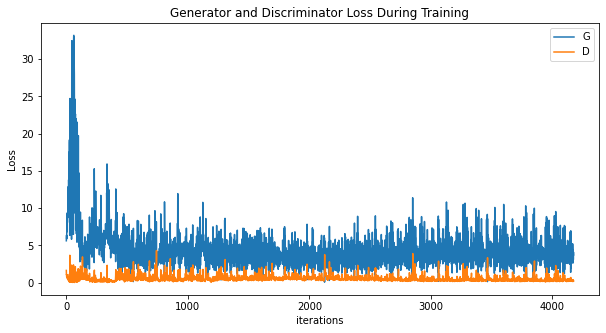

In [17]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

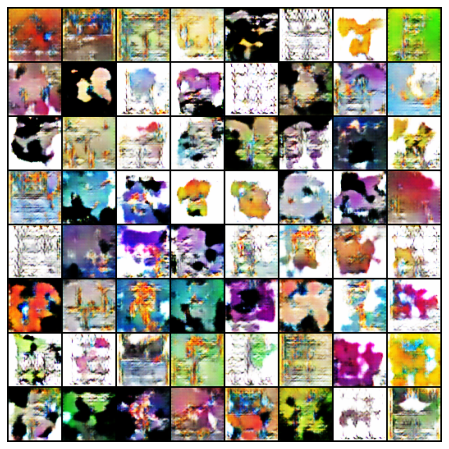

In [18]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

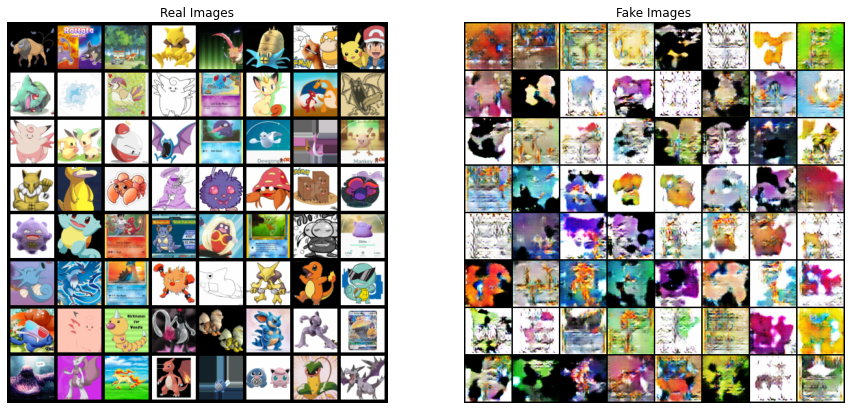

In [19]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()